# Insulator Segmentation

## 2. Imports

In [1]:
import os
import gc
import cv2
import numpy as np
from pathlib import Path
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler

import albumentations as A
from albumentations.pytorch import ToTensorV2
from efficientnet_pytorch import EfficientNet

def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'✅ Device: {device}')
if torch.cuda.is_available():
    print(f'✅ GPU: {torch.cuda.get_device_name(0)}')
    print(f'✅ GPUs: {torch.cuda.device_count()}')
print(f'✅ NumPy: {np.__version__}')
print(f'✅ PyTorch: {torch.__version__}')

✅ Device: cuda
✅ GPU: Tesla T4
✅ GPUs: 2
✅ NumPy: 1.26.4
✅ PyTorch: 2.6.0+cu124


## 3. Configuration

In [2]:
class Config:
    DATA_DIR = Path('/kaggle/input/insulator-dataset/train/train')
    TEST_DIR = Path('/kaggle/input/insulator-dataset/test/test')
    WORK_DIR = Path('/kaggle/working')
    CHECKPOINT_DIR = WORK_DIR / 'checkpoints'
    PREDICTION_DIR = WORK_DIR / 'predictions'
    
    CHECKPOINT_DIR.mkdir(exist_ok=True, parents=True)
    PREDICTION_DIR.mkdir(exist_ok=True, parents=True)
    
    ENCODER = 'resnet34'
    
    IMG_SIZE = 512
    BATCH_SIZE = 16
    NUM_EPOCHS = 40
    LEARNING_RATE = 1e-4
    WEIGHT_DECAY = 1e-5
    NUM_WORKERS = 2
    VAL_SPLIT = 0.15
    EARLY_STOPPING_PATIENCE = 7
    USE_TTA = True
    OPTIMIZE_THRESHOLD = True
    SAVE_EVERY_N_EPOCHS = 5

cfg = Config()

print(f"⚙️  {cfg.NUM_EPOCHS} epochs, batch {cfg.BATCH_SIZE}, TTA={cfg.USE_TTA}")

⚙️  40 epochs, batch 16, TTA=True


## 4. U-Net Model (CORRECTED Architecture)

In [3]:
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.conv(x)

class UNetResNet(nn.Module):
    def __init__(self, encoder_name='resnet34', pretrained=True):
        super().__init__()
        
        # ResNet encoder
        import torchvision.models as models
        if encoder_name == 'resnet34':
            resnet = models.resnet34(pretrained=pretrained)
        else:
            resnet = models.resnet50(pretrained=pretrained)
        
        # Encoder layers
        self.enc0 = nn.Sequential(resnet.conv1, resnet.bn1, resnet.relu)
        self.enc1 = nn.Sequential(resnet.maxpool, resnet.layer1)
        self.enc2 = resnet.layer2
        self.enc3 = resnet.layer3
        self.enc4 = resnet.layer4
        
        # Decoder - ResNet34: [64, 64, 128, 256, 512]
        self.up1 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.conv1 = ConvBlock(256 + 256, 256)
        
        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.conv2 = ConvBlock(128 + 128, 128)
        
        self.up3 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv3 = ConvBlock(64 + 64, 64)
        
        self.up4 = nn.ConvTranspose2d(64, 64, 2, stride=2)
        self.conv4 = ConvBlock(64 + 64, 64)
        
        self.up5 = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.conv5 = ConvBlock(32, 32)
        
        self.final = nn.Conv2d(32, 1, 1)
    
    def forward(self, x):
        # Encoder
        e0 = self.enc0(x)   # 64
        e1 = self.enc1(e0)  # 64
        e2 = self.enc2(e1)  # 128
        e3 = self.enc3(e2)  # 256
        e4 = self.enc4(e3)  # 512
        
        # Decoder
        x = self.up1(e4)
        x = torch.cat([x, e3], dim=1)
        x = self.conv1(x)
        
        x = self.up2(x)
        x = torch.cat([x, e2], dim=1)
        x = self.conv2(x)
        
        x = self.up3(x)
        x = torch.cat([x, e1], dim=1)
        x = self.conv3(x)
        
        x = self.up4(x)
        x = torch.cat([x, e0], dim=1)
        x = self.conv4(x)
        
        x = self.up5(x)
        x = self.conv5(x)
        
        return self.final(x)

print("✅ U-Net + ResNet34 ready")

✅ U-Net + ResNet34 ready


## 5. Data Loading

In [4]:
def get_file_paths(data_dir, test_dir):
    train_img_dir = data_dir / 'images'
    train_mask_dir = data_dir / 'masks'
    test_img_dir = test_dir / 'images'
    
    train_images = sorted(list(train_img_dir.glob('*.jpg')))
    train_masks = sorted(list(train_mask_dir.glob('*.png')))
    test_images = sorted(list(test_img_dir.glob('*.jpg')))
    
    print(f"✅ Train: {len(train_images)} images, {len(train_masks)} masks")
    print(f"✅ Test: {len(test_images)} images")
    
    assert len(train_images) == len(train_masks)
    return train_images, train_masks, test_images

train_images, train_masks, test_images = get_file_paths(cfg.DATA_DIR, cfg.TEST_DIR)

train_imgs, val_imgs, train_msks, val_msks = train_test_split(
    train_images, train_masks, test_size=cfg.VAL_SPLIT, random_state=42
)

print(f"📊 Split: {len(train_imgs)} train, {len(val_imgs)} val")

✅ Train: 7000 images, 7000 masks
✅ Test: 4000 images
📊 Split: 5950 train, 1050 val


## 6. Augmentations

In [5]:
def get_train_transforms(img_size=512):
    return A.Compose([
        A.Resize(img_size, img_size),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.15, rotate_limit=45, p=0.6),
        A.OneOf([A.RandomBrightnessContrast(p=1), A.HueSaturationValue(p=1)], p=0.5),
        A.OneOf([A.GaussNoise(p=1), A.GaussianBlur(p=1)], p=0.3),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ])

def get_val_transforms(img_size=512):
    return A.Compose([
        A.Resize(img_size, img_size),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ])

print("✅ Augmentations ready")

✅ Augmentations ready


## 7. Dataset & DataLoaders

In [6]:
class InsulatorDataset(Dataset):
    def __init__(self, image_paths, mask_paths=None, transforms=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transforms = transforms
        self.is_test = mask_paths is None
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = cv2.imread(str(img_path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.is_test:
            if self.transforms:
                image = self.transforms(image=image)['image']
            return image, str(img_path.name)
        else:
            mask_path = self.mask_paths[idx]
            mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
            mask = (mask > 127).astype(np.float32)
            
            if self.transforms:
                augmented = self.transforms(image=image, mask=mask)
                image = augmented['image']
                mask = augmented['mask']
            
            mask = mask.unsqueeze(0)
            return image, mask

# Create datasets
train_dataset = InsulatorDataset(train_imgs, train_msks, get_train_transforms(cfg.IMG_SIZE))
val_dataset = InsulatorDataset(val_imgs, val_msks, get_val_transforms(cfg.IMG_SIZE))
test_dataset = InsulatorDataset(test_images, None, get_val_transforms(cfg.IMG_SIZE))

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=cfg.BATCH_SIZE, shuffle=True, 
                         num_workers=cfg.NUM_WORKERS, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=cfg.BATCH_SIZE, shuffle=False, 
                       num_workers=cfg.NUM_WORKERS, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=cfg.BATCH_SIZE, shuffle=False, 
                        num_workers=cfg.NUM_WORKERS, pin_memory=True)

print(f"✅ {len(train_loader)} train, {len(val_loader)} val, {len(test_loader)} test batches")

✅ 372 train, 66 val, 250 test batches


## 8. Model, Loss & Metrics

In [7]:
model = UNetResNet(encoder_name=cfg.ENCODER, pretrained=True)

if torch.cuda.device_count() > 1:
    print(f"🚀 Using {torch.cuda.device_count()} GPUs")
    model = nn.DataParallel(model)

model = model.to(device)
print(f"✅ Model on {device}")

# Loss
class DiceBCELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss()
    
    def forward(self, logits, targets):
        bce = self.bce(logits, targets)
        probs = torch.sigmoid(logits)
        intersection = (probs * targets).sum(dim=(2, 3))
        union = probs.sum(dim=(2, 3)) + targets.sum(dim=(2, 3))
        dice = (2. * intersection + 1e-6) / (union + 1e-6)
        return 0.5 * bce + 0.5 * (1 - dice.mean())

# Metric
def dice_coefficient(pred, target, threshold=0.5):
    pred = (pred > threshold).float()
    intersection = (pred * target).sum(dim=(2, 3))
    union = pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3))
    return ((2. * intersection + 1e-6) / (union + 1e-6)).mean()

criterion = DiceBCELoss()
print("✅ Loss & metrics ready")

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 210MB/s]


🚀 Using 2 GPUs
✅ Model on cuda
✅ Loss & metrics ready


## 9. Training Functions

In [8]:
def train_epoch(model, loader, criterion, optimizer, scaler, device):
    model.train()
    total_loss, total_dice = 0, 0
    
    for images, masks in tqdm(loader, desc='Train'):
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        
        with autocast():
            logits = model(images)
            loss = criterion(logits, masks)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        with torch.no_grad():
            dice = dice_coefficient(torch.sigmoid(logits), masks)
        
        total_loss += loss.item()
        total_dice += dice.item()
    
    return total_loss / len(loader), total_dice / len(loader)

def validate_epoch(model, loader, criterion, device):
    model.eval()
    total_loss, total_dice = 0, 0
    
    with torch.no_grad():
        for images, masks in tqdm(loader, desc='Val'):
            images, masks = images.to(device), masks.to(device)
            logits = model(images)
            loss = criterion(logits, masks)
            dice = dice_coefficient(torch.sigmoid(logits), masks)
            total_loss += loss.item()
            total_dice += dice.item()
    
    return total_loss / len(loader), total_dice / len(loader)

print("✅ Training functions ready")

✅ Training functions ready


## 10. Checkpoint Manager

In [9]:
class CheckpointManager:
    def __init__(self, checkpoint_dir):
        self.checkpoint_dir = Path(checkpoint_dir)
        self.checkpoint_dir.mkdir(exist_ok=True, parents=True)
        self.best_score = -np.inf
    
    def save(self, model, optimizer, scaler, epoch, metrics, is_best=False):
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.module.state_dict() if hasattr(model, 'module') else model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scaler_state_dict': scaler.state_dict(),
            'metrics': metrics,
        }
        torch.save(checkpoint, self.checkpoint_dir / 'latest.pth')
        if is_best:
            torch.save(checkpoint, self.checkpoint_dir / 'best.pth')
            self.best_score = metrics['val_dice']
            print(f"💾 Best: {metrics['val_dice']:.4f}")
    
    def load(self, model, optimizer=None, scaler=None, name='best.pth'):
        path = self.checkpoint_dir / name
        if not path.exists():
            return None
        checkpoint = torch.load(path, map_location=device)
        if hasattr(model, 'module'):
            model.module.load_state_dict(checkpoint['model_state_dict'])
        else:
            model.load_state_dict(checkpoint['model_state_dict'])
        if optimizer:
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        if scaler:
            scaler.load_state_dict(checkpoint['scaler_state_dict'])
        print(f"✅ Loaded epoch {checkpoint['epoch']}")
        return checkpoint

ckpt_mgr = CheckpointManager(cfg.CHECKPOINT_DIR)
print("✅ Checkpoint manager ready")

✅ Checkpoint manager ready


## 11. Training Loop

In [10]:
optimizer = optim.AdamW(model.parameters(), lr=cfg.LEARNING_RATE, weight_decay=cfg.WEIGHT_DECAY)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=15, T_mult=2, eta_min=1e-6)
scaler = GradScaler()

history = {'train_loss': [], 'train_dice': [], 'val_loss': [], 'val_dice': []}
best_val_dice, patience = -np.inf, 0

print("\n" + "="*70)
print("🏁 TRAINING START")
print("="*70 + "\n")

for epoch in range(1, cfg.NUM_EPOCHS + 1):
    print(f"Epoch {epoch}/{cfg.NUM_EPOCHS}")
    
    train_loss, train_dice = train_epoch(model, train_loader, criterion, optimizer, scaler, device)
    val_loss, val_dice = validate_epoch(model, val_loader, criterion, device)
    scheduler.step()
    
    history['train_loss'].append(train_loss)
    history['train_dice'].append(train_dice)
    history['val_loss'].append(val_loss)
    history['val_dice'].append(val_dice)
    
    print(f"Train: Loss={train_loss:.4f}, Dice={train_dice:.4f}")
    print(f"Val:   Loss={val_loss:.4f}, Dice={val_dice:.4f}")
    
    is_best = val_dice > best_val_dice
    
    if epoch % cfg.SAVE_EVERY_N_EPOCHS == 0 or is_best:
        ckpt_mgr.save(model, optimizer, scaler, epoch, 
                     {'train_loss': train_loss, 'train_dice': train_dice,
                      'val_loss': val_loss, 'val_dice': val_dice}, is_best)
    
    if is_best:
        best_val_dice = val_dice
        patience = 0
    else:
        patience += 1
        if patience >= cfg.EARLY_STOPPING_PATIENCE:
            print(f"\n⚠️ Early stopping")
            break
    
    gc.collect()
    torch.cuda.empty_cache()

print(f"\n✅ Training Complete! Best Dice: {best_val_dice:.4f}")


🏁 TRAINING START

Epoch 1/40


Train:   0%|          | 0/372 [00:00<?, ?it/s]

Val:   0%|          | 0/66 [00:00<?, ?it/s]

Train: Loss=0.2028, Dice=0.9604
Val:   Loss=0.1200, Dice=0.9820
💾 Best: 0.9820
Epoch 2/40


Train:   0%|          | 0/372 [00:00<?, ?it/s]

Val:   0%|          | 0/66 [00:00<?, ?it/s]

Train: Loss=0.1107, Dice=0.9814
Val:   Loss=0.0784, Dice=0.9844
💾 Best: 0.9844
Epoch 3/40


Train:   0%|          | 0/372 [00:00<?, ?it/s]

Val:   0%|          | 0/66 [00:00<?, ?it/s]

Train: Loss=0.0763, Dice=0.9831
Val:   Loss=0.0548, Dice=0.9862
💾 Best: 0.9862
Epoch 4/40


Train:   0%|          | 0/372 [00:00<?, ?it/s]

Val:   0%|          | 0/66 [00:00<?, ?it/s]

Train: Loss=0.0587, Dice=0.9840
Val:   Loss=0.0498, Dice=0.9860
Epoch 5/40


Train:   0%|          | 0/372 [00:00<?, ?it/s]

Val:   0%|          | 0/66 [00:00<?, ?it/s]

Train: Loss=0.0488, Dice=0.9847
Val:   Loss=0.0397, Dice=0.9864
💾 Best: 0.9864
Epoch 6/40


Train:   0%|          | 0/372 [00:00<?, ?it/s]

Val:   0%|          | 0/66 [00:00<?, ?it/s]

Train: Loss=0.0417, Dice=0.9857
Val:   Loss=0.0374, Dice=0.9874
💾 Best: 0.9874
Epoch 7/40


Train:   0%|          | 0/372 [00:00<?, ?it/s]

Val:   0%|          | 0/66 [00:00<?, ?it/s]

Train: Loss=0.0382, Dice=0.9858
Val:   Loss=0.0337, Dice=0.9876
💾 Best: 0.9876
Epoch 8/40


Train:   0%|          | 0/372 [00:00<?, ?it/s]

Val:   0%|          | 0/66 [00:00<?, ?it/s]

Train: Loss=0.0343, Dice=0.9868
Val:   Loss=0.0295, Dice=0.9884
💾 Best: 0.9884
Epoch 9/40


Train:   0%|          | 0/372 [00:00<?, ?it/s]

Val:   0%|          | 0/66 [00:00<?, ?it/s]

Train: Loss=0.0324, Dice=0.9870
Val:   Loss=0.0287, Dice=0.9885
💾 Best: 0.9885
Epoch 10/40


Train:   0%|          | 0/372 [00:00<?, ?it/s]

Val:   0%|          | 0/66 [00:00<?, ?it/s]

Train: Loss=0.0303, Dice=0.9876
Val:   Loss=0.0269, Dice=0.9888
💾 Best: 0.9888
Epoch 11/40


Train:   0%|          | 0/372 [00:00<?, ?it/s]

Val:   0%|          | 0/66 [00:00<?, ?it/s]

Train: Loss=0.0292, Dice=0.9878
Val:   Loss=0.0268, Dice=0.9890
💾 Best: 0.9890
Epoch 12/40


Train:   0%|          | 0/372 [00:00<?, ?it/s]

Val:   0%|          | 0/66 [00:00<?, ?it/s]

Train: Loss=0.0283, Dice=0.9880
Val:   Loss=0.0262, Dice=0.9892
💾 Best: 0.9892
Epoch 13/40


Train:   0%|          | 0/372 [00:00<?, ?it/s]

Val:   0%|          | 0/66 [00:00<?, ?it/s]

Train: Loss=0.0275, Dice=0.9882
Val:   Loss=0.0254, Dice=0.9893
💾 Best: 0.9893
Epoch 14/40


Train:   0%|          | 0/372 [00:00<?, ?it/s]

Val:   0%|          | 0/66 [00:00<?, ?it/s]

Train: Loss=0.0271, Dice=0.9883
Val:   Loss=0.0250, Dice=0.9894
💾 Best: 0.9894
Epoch 15/40


Train:   0%|          | 0/372 [00:00<?, ?it/s]

Val:   0%|          | 0/66 [00:00<?, ?it/s]

Train: Loss=0.0269, Dice=0.9884
Val:   Loss=0.0248, Dice=0.9895
💾 Best: 0.9895
Epoch 16/40


Train:   0%|          | 0/372 [00:00<?, ?it/s]

Val:   0%|          | 0/66 [00:00<?, ?it/s]

Train: Loss=0.0312, Dice=0.9858
Val:   Loss=0.0315, Dice=0.9852
Epoch 17/40


Train:   0%|          | 0/372 [00:00<?, ?it/s]

Val:   0%|          | 0/66 [00:00<?, ?it/s]

Train: Loss=0.0289, Dice=0.9864
Val:   Loss=0.0279, Dice=0.9865
Epoch 18/40


Train:   0%|          | 0/372 [00:00<?, ?it/s]

Val:   0%|          | 0/66 [00:00<?, ?it/s]

Train: Loss=0.0284, Dice=0.9864
Val:   Loss=0.0264, Dice=0.9873
Epoch 19/40


Train:   0%|          | 0/372 [00:00<?, ?it/s]

Val:   0%|          | 0/66 [00:00<?, ?it/s]

Train: Loss=0.0273, Dice=0.9867
Val:   Loss=0.0238, Dice=0.9884
Epoch 20/40


Train:   0%|          | 0/372 [00:00<?, ?it/s]

Val:   0%|          | 0/66 [00:00<?, ?it/s]

Train: Loss=0.0267, Dice=0.9869
Val:   Loss=0.0272, Dice=0.9866
Epoch 21/40


Train:   0%|          | 0/372 [00:00<?, ?it/s]

Val:   0%|          | 0/66 [00:00<?, ?it/s]

Train: Loss=0.0261, Dice=0.9871
Val:   Loss=0.0244, Dice=0.9881
Epoch 22/40


Train:   0%|          | 0/372 [00:00<?, ?it/s]

Val:   0%|          | 0/66 [00:00<?, ?it/s]

Train: Loss=0.0255, Dice=0.9873
Val:   Loss=0.0229, Dice=0.9887

⚠️ Early stopping

✅ Training Complete! Best Dice: 0.9895


## 12. Threshold Optimization

In [11]:
if cfg.OPTIMIZE_THRESHOLD:
    print("\n🔍 Optimizing threshold...")
    ckpt_mgr.load(model, name='best.pth')
    model.eval()
    
    best_threshold, best_score = 0.5, 0
    
    for thresh in np.arange(0.3, 0.7, 0.05):
        total = 0
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                probs = torch.sigmoid(model(images))
                total += dice_coefficient(probs, masks, thresh).item()
        
        avg = total / len(val_loader)
        print(f"  Threshold {thresh:.2f}: Dice = {avg:.4f}")
        
        if avg > best_score:
            best_score = avg
            best_threshold = thresh
    
    print(f"\n✅ Best threshold: {best_threshold:.2f} (Dice: {best_score:.4f})")
else:
    best_threshold = 0.5
    print(f"Using default threshold: {best_threshold}")


🔍 Optimizing threshold...
✅ Loaded epoch 15
  Threshold 0.30: Dice = 0.9887
  Threshold 0.35: Dice = 0.9890
  Threshold 0.40: Dice = 0.9893
  Threshold 0.45: Dice = 0.9894
  Threshold 0.50: Dice = 0.9895
  Threshold 0.55: Dice = 0.9895
  Threshold 0.60: Dice = 0.9894
  Threshold 0.65: Dice = 0.9892

✅ Best threshold: 0.50 (Dice: 0.9895)


## 13. Create Submission Archive

In [14]:
from IPython.display import FileLink
FileLink('/kaggle/working/submission.zip')

/kaggle/working/submission.zip

✅ Loaded epoch 15
📊 Статистика предсказания:
  Min: 0.0025
  Max: 0.9988
  Mean: 0.6684


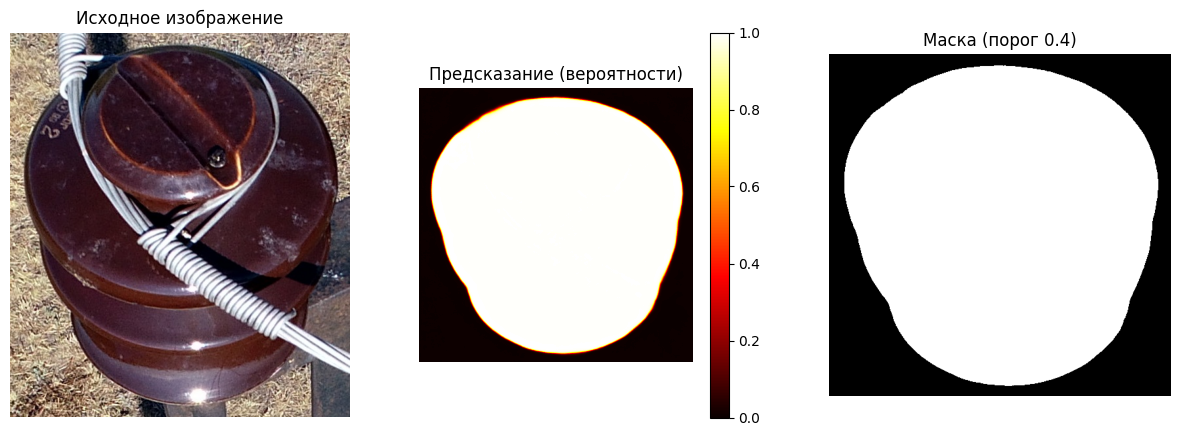

In [20]:
# Тест модели
ckpt_mgr.load(model, name='best.pth')
model.eval()

test_img = test_images[0]
image = cv2.cvtColor(cv2.imread(str(test_img)), cv2.COLOR_BGR2RGB)
aug = get_val_transforms(cfg.IMG_SIZE)(image=image)
img_t = aug['image'].unsqueeze(0).to(device)

with torch.no_grad():
    pred = torch.sigmoid(model(img_t)).cpu().numpy()[0, 0]

print(f"📊 Статистика предсказания:")
print(f"  Min: {pred.min():.4f}")
print(f"  Max: {pred.max():.4f}") 
print(f"  Mean: {pred.mean():.4f}")

# Визуализация
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.imshow(image)
plt.title('Исходное изображение')
plt.axis('off')

plt.subplot(132)
plt.imshow(pred, cmap='hot', vmin=0, vmax=1)
plt.colorbar()
plt.title('Предсказание (вероятности)')
plt.axis('off')

plt.subplot(133)
plt.imshow(pred > 0.4, cmap='gray')
plt.title('Маска (порог 0.4)')
plt.axis('off')

plt.savefig('/kaggle/working/test_prediction.png', dpi=100, bbox_inches='tight')
plt.show()

In [1]:
import cv2
from pathlib import Path
from tqdm import tqdm

# Ваш путь к маскам
masks_dir = Path('/kaggle/working/predictions') 
output_dir = Path('/kaggle/working/predictions_fixed')
output_dir.mkdir(exist_ok=True)

for mask_file in tqdm(list(masks_dir.glob('*.png'))):
    mask = cv2.imread(str(mask_file), cv2.IMREAD_GRAYSCALE)
    # Конвертировать 0-1 в 0-255
    mask_fixed = (mask * 255).astype(np.uint8) if mask.max() <= 1 else mask
    cv2.imwrite(str(output_dir / mask_file.name), mask_fixed)

print("✅ Готово! Создайте ZIP из этой папки")

0it [00:00, ?it/s]

✅ Готово! Создайте ZIP из этой папки
